## Lab - Using Interpretable Features for Model Debugging

In our lecture on interpretable features, you learned about the importance of using interpretable features for interpretable models. As we talked about, one of the benefits of interpretable machine learning is it makes it easier to identify the source of a problem with a deployed model.

In this lab, we'll be working with a modified version of the Ames Housing Dataset (CITE). In this dataset, each row represents a single house in Ames Iowa, and our model is trained to predict the final sale price of the house.

In our hypothetical scenario, a real estate agent has deployed a model to help them set the initial sale price houses newly on the market. However, despite decent train and test scores during model training, the agent has found that the house predictions are terrible in the real world. They suspect something went wrong with the data, and want to use methods from *XAI* (explainable AI) to identify the problem.

Your task will be to try to find the issue with the data. You will try transforming the data in different ways to train multiple models with different levels of *feature interpretability*. There are **two mistakes** intentionally added to the dataset.

### Data Setup

Run the cells below to install libraries, load in the (flawed) dataset, and take an initial look at the data. **After running the first (pip install) cell, make sure to restart your kernel by using Kernel -> Restart in the toolbar, the continue running from the second cell.**

In [1]:
%pip install -qU pyreal "dask[dataframe]" featuretools "matplotlib==3.7.2" "plotnine"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.1/620.1 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.5/244.5 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [1]:
import pyreal
pyreal.__version__

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


'0.4.9'

In [2]:
import pandas as pd
import numpy as np
import lightgbm
from pyreal.transformers import OneHotEncoder, DataFrameWrapper, fit_transformers, run_transformers
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
!pwd

/content


In [5]:
%cd ./drive/MyDrive/dcai_lab/interpretable_features/

/content/drive/MyDrive/dcai_lab/interpretable_features


In [6]:
!pwd

/content/drive/MyDrive/dcai_lab/interpretable_features


In [29]:
# !pip freeze > requirements.txt

In [8]:
def one_hot_encode(X_train, X_test):
    categorical_features = X_train.select_dtypes(exclude=[np.number]).columns
    ohe = OneHotEncoder(columns=categorical_features)

    ohe.fit(pd.concat((X_train, X_test), axis=0))

    return ohe.transform(X_train), ohe.transform(X_test)

def fit_model(X_train, y_train):
    return lightgbm.LGBMRegressor().fit(X_train, y_train)

train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_data.csv")

## My Code starts ##
train_data.drop(["Alley", "MasVnrType"], axis=1, inplace=True)
train_data.dropna(inplace=True)
test_data.drop(["Alley", "MasVnrType"], axis=1, inplace=True)
test_data.dropna(inplace=True)
## My Code ends ##

y_train = train_data.SalePrice
X_train = train_data.drop("SalePrice", axis=1)

y_test = test_data.SalePrice
X_test = test_data.drop("SalePrice", axis=1)

X_train_model, X_test_model = one_hot_encode(X_train, X_test)
feature_df = pd.read_csv("feature_descriptions.csv") # includes information about features

X_train.head()

,LotFrontage,LotArea,Street,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,Heating,CentralAir,Electrical,GarageType,GarageFinish,Fence,MiscFeature,MoSold,SaleType,SaleCondition
0,107.0,13891,2,4,4,3,1,5,2006,2006,...,GasA,Y,SBrkr,Attchd,Fin,No,No,Sep,New,Partial
1,50.0,6060,2,4,4,3,7,5,1939,1950,...,GasA,Y,SBrkr,Detchd,Unf,MnPrv,No,Jun,WD,Normal
2,60.0,6000,2,4,4,3,5,6,1941,1950,...,GasA,Y,SBrkr,Detchd,Unf,No,No,Mar,WD,Normal
3,70.0,7728,2,4,4,3,6,6,1962,1962,...,GasA,Y,SBrkr,Attchd,Unf,GdWo,No,May,WD,Normal
4,80.0,10480,2,4,4,3,4,6,1976,1976,...,GasA,Y,SBrkr,Attchd,RFn,No,No,Sep,WD,Normal


### Generating Explanations

To generate explanations throughout this lab, we will be using the popular explanation library [shap](https://shap.readthedocs.io/en/latest/). SHAP is a *model agnostic* explanation tool, meaning it can be used to explain any ML model, regardless of architecture --- however, as we will see, its explanations are less than useful when using uninterpretable features.

The shap library offers many different (plotting options)[https://shap.readthedocs.io/en/latest/api_examples.html#plots], you can try multiple out to see what works best for your task. Some plots provide *local explantions*, which explain the logic behind a single prediction. For this lab, you will be working with *global explanations*, which explain the model's logic overall.

As a start, we recommend you try the **beeswarm** plot. This chart lists the feature the model considers most important on top, with reducing importance going down the y-axis. Each point represents a line in the dataset, with the color representing the value of the feature. The SHAP impact value, on the x-axis represents how much that feature value contributed to the model prediction. A higher value along the x-axis means that feature was highly positively correlated with the model prediction, while a lower value means it was negatively correlated. A SHAP value of zero means that feature value had no effect on the model prediction.

For example, in the sample visualization below, higher median income and lower populations in house blocks tends to result in higher house prices (which makes sense!)

![example explanation](example_explanation.png)

Run the cell below for two helper functions that will get you started on generating explanations.

In [9]:
import shap

def explain(model, X_train):
    """
    Explain a model with a beeswarm plot.

    model: a machine learning model
    X_train: a dataset of valid inputs to model
    """
    explainer = shap.explainers.Tree(model, X_train)
    shap_values = explainer(X_train)

    shap.plots.beeswarm(shap_values, max_display=10)

def explain_feature(model, X_train, feature_name):
    """
    Generate an explanation for the impact of a specific
    feature on model predictions.

    model: a machine learning model
    X_train: a dataset of valid inputs to model
    feature_name: string, the name of a feature to investigate
    """
    explainer = shap.explainers.Tree(model, X_train)
    shap_values = explainer(X_train)

    shap.plots.scatter(shap_values[:, feature_name])

### Feature Transforms 1: PCA

We will begin by running a [PCA (Principle Component Analysis)](https://builtin.com/data-science/step-step-explanation-principal-component-analysis) on the data. Run the cell below to standardize and PCA transform the data, and train a light GBM model. Note the performance (given as an [R^2](https://www.geeksforgeeks.org/ml-r-squared-in-regression-analysis/) score).

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = DataFrameWrapper(StandardScaler())

X_train_std = scaler.fit_transform(X_train_model)
X_test_std = scaler.transform(X_test_model)

pca = PCA(n_components=0.95)
pca.fit(X_train_std)

X_train_pca = pd.DataFrame(pca.transform(X_train_std), columns=pca.get_feature_names_out())
X_test_pca = pd.DataFrame(pca.transform(X_test_std), columns=pca.get_feature_names_out())

model_pca = fit_model(X_train_pca, y_train)

print("Number of PCA components used: %i" % pca.n_components_)
print("R^2 Score (PCA): %.3f" % model_pca.score(X_test_pca, y_test))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38505
[LightGBM] [Info] Number of data points in the train set: 1236, number of used features: 151
[LightGBM] [Info] Start training from score 180646.253236
Number of PCA components used: 151
R^2 Score (PCA): 0.861


In the cell below, use the explanation helper functions (or others from the shap library/other explanation libraries you may be interested in trying) to generate some explanations of the model's prediction. Think about what additional steps you may need to take to identify the source of poor performance.

In [11]:
X_train_pca.head()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca141,pca142,pca143,pca144,pca145,pca146,pca147,pca148,pca149,pca150
0,9.152193,0.555316,-1.376740,4.236074,-2.876666,0.077268,-0.132220,-1.401284,0.318791,-1.829482,...,-0.125812,0.785275,0.256396,0.282060,1.371175,0.439349,0.375565,-0.518703,-0.310085,-0.827631
1,-6.018227,2.667527,-0.711028,-1.493395,-2.475969,-0.080363,-0.559201,0.518803,0.311959,-0.218960,...,-0.330803,0.756737,0.786491,-0.652638,-0.095306,0.410744,0.295988,0.279337,0.335285,-1.147143
2,-3.677825,1.423451,1.171601,-2.031712,-3.805862,-1.802228,-0.716396,-0.256764,0.861462,0.019564,...,-0.831549,1.109735,-0.665143,-0.025919,0.040965,-0.133495,-0.007589,0.309962,0.505371,1.118777
3,-2.631556,-3.428856,0.297350,0.762157,2.111592,0.647302,3.042493,-1.093635,-0.733556,-0.419131,...,-0.053540,0.799380,-0.240330,0.123771,-0.290428,0.039462,0.755755,-0.066308,-0.449543,-0.703191
4,1.433555,-0.424970,3.550227,-0.929108,2.876990,0.595552,0.685344,-1.065133,-1.445274,-1.184056,...,-0.667024,-0.285127,0.209647,-0.124719,-0.212201,0.326182,-0.288553,0.291642,-0.124573,0.252440


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


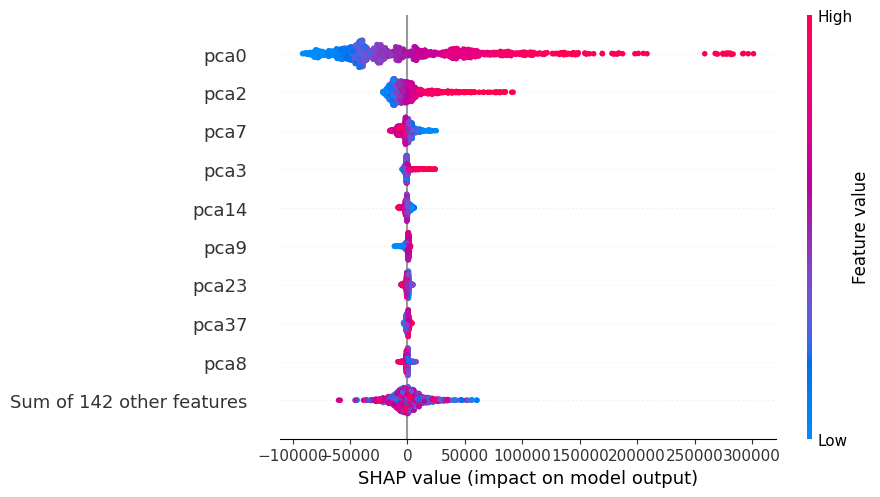

In [12]:
# Generate an explanation of the PCA model, and see if you can identify the data flaw
explain(model_pca, X_train_pca)

 99%|===================| 1225/1236 [00:11<00:00]       

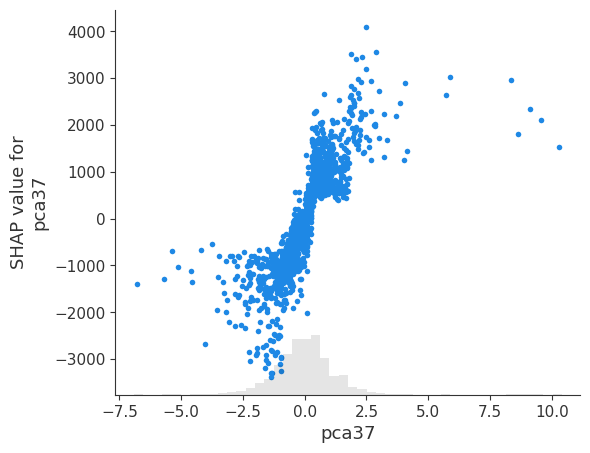

In [13]:
explain_feature(model_pca, X_train_pca, "pca37")

### Feature Transforms 2: Automatic Feature Engineering

Next, we will try a different set of transformations using an automatic feature engineering tool - [Featuretools](https://www.featuretools.com/). This is a powerful library that makes it possible to try hundreds of feature engineering options with just a few lines of code. There are many situations where this is a very useful process - but as we'll see below, automatic feature engineering without care can lead to less interpretable features.

Run the cell below to generate a significantly larger dataset of engineered features. This process may be slow - you can load in the pretrained results of the engineering process by setting `load_pretrained = True`

In [14]:
import featuretools as ft

load_pretrained = False

def make_entity_set(X):
    es = ft.EntitySet(id="houses")

    X_with_ind = X.copy()
    X_with_ind['index'] = X_with_ind.index

    es = es.add_dataframe(
      dataframe_name="houses",
      dataframe=X_with_ind,
      index="index",
    )

    return es

def feature_engineer(es, num_to_engineer=15, primitives=None):
    # To avoid large computation times, we
    ignore_features = list(feature_df["name"][num_to_engineer:])

    if primitives is None:
        # To avoid large computation times, we'll just work with a truncated set of options
        primitives = ['multiply_numeric', "greater_than", "divide_by_feature", "cosine", "tangent"]

    feature_matrix, feature_defs = ft.dfs(
        entityset=es,
        target_dataframe_name="houses",
        trans_primitives=primitives,
        ignore_columns={"houses": ignore_features},
        max_depth=1,
        max_features=1000
    )

    return feature_matrix, feature_defs

if load_pretrained:
    X_train_ft = pd.read_csv("X_train_ft.csv")
    X_test_ft = pd.read_csv("X_test_ft.csv")

else:
    print("Starting deep feature synthesis on training data")
    X_train_ft, feature_defs = feature_engineer(make_entity_set(X_train))

    print("Starting feature engineering on testing data")
    X_test_ft = ft.calculate_feature_matrix(feature_defs, make_entity_set(X_test))

X_train_ft_model, X_test_ft_model = one_hot_encode(X_train_ft, X_test_ft)

model_ft = fit_model(X_train_ft_model, y_train)
print("R2 Score (Featuretools):", model_ft.score(X_test_ft_model, y_test))

'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.


Starting deep feature synthesis on training data


Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected,

Starting feature engineering on testing data


Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected,

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14472
[LightGBM] [Info] Number of data points in the train set: 1236, number of used features: 539
[LightGBM] [Info] Start training from score 180646.253236
R2 Score (Featuretools): 0.8133396480813935


Once again, try generating explanations on the generated data, and see if you can guess at the flaw in the data.

 91%|==================  | 1126/1236 [00:11<00:01]       No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


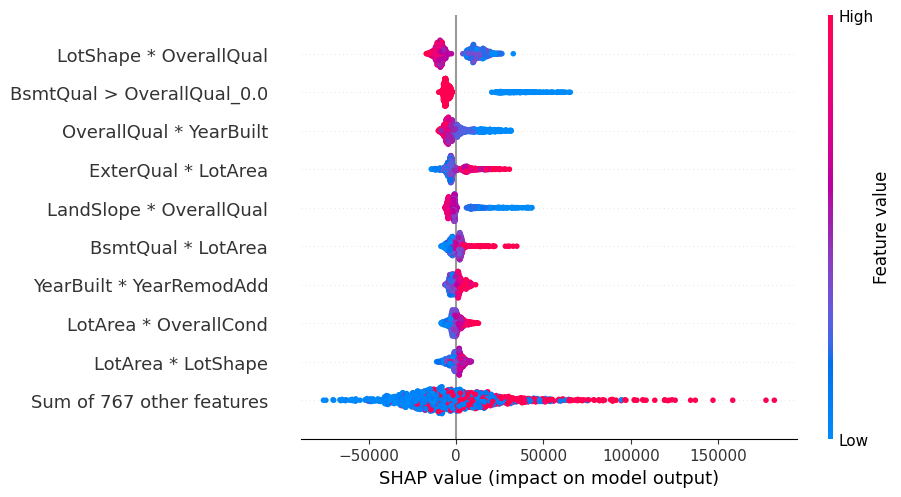

In [15]:
# Generate explanations here
explain(model_ft, X_train_ft_model)

 98%|===================| 1206/1236 [00:11<00:00]       

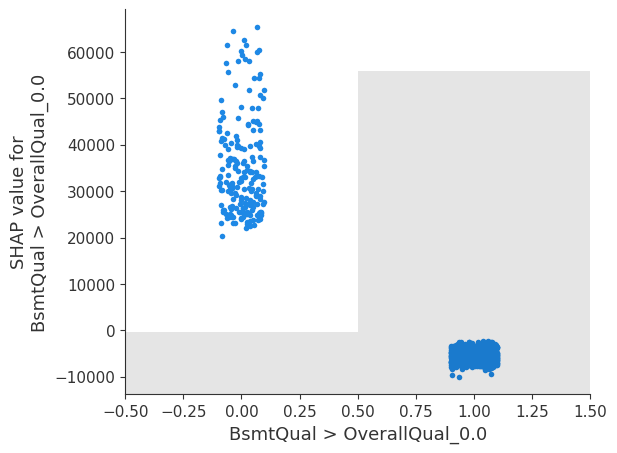

In [16]:
explain_feature(model_ft, X_train_ft_model, "BsmtQual > OverallQual_0.0")

### Basic Feature Transformations

In many datasets, complex feature engineering does not offer a lot (or any!) boost in model performance, while lowering the interpretability of features. In this dataset, we happened to be given data already turned into useful features. Again, we will train a model on a set of features. Then, try generating some explanations and see if you can guess at the data flaw.

In [17]:
model_orig = fit_model(X_train_std, y_train)
print("R2 Score (Original):", model_orig.score(X_test_std, y_test))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3596
[LightGBM] [Info] Number of data points in the train set: 1236, number of used features: 162
[LightGBM] [Info] Start training from score 180646.253236
R2 Score (Original): 0.9242132752240463


 89%|==================  | 1101/1236 [00:11<00:01]       No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


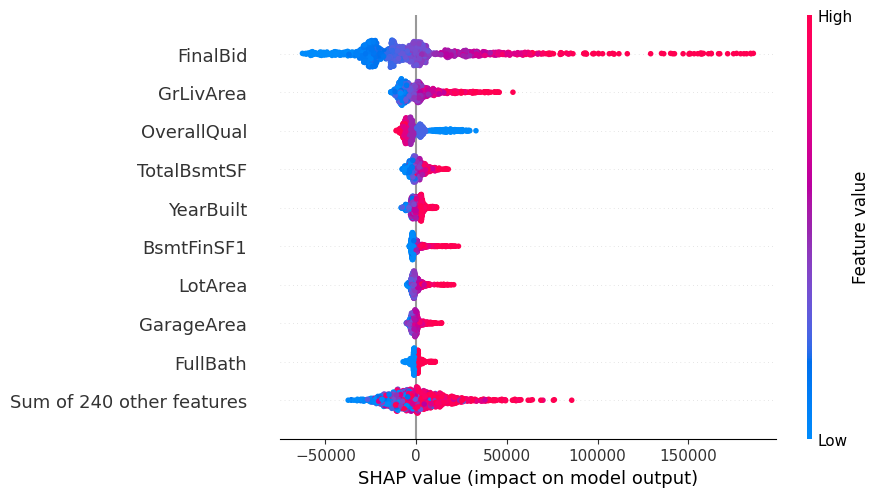

In [18]:
# Generate explanations here
explain(model_orig, X_train_std)

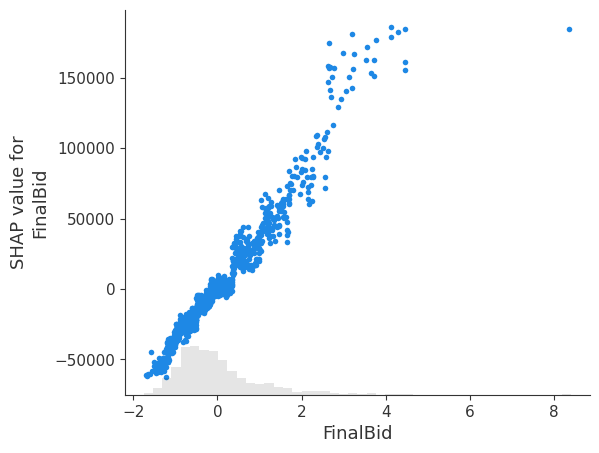

In [19]:
explain_feature(model_orig, X_train_std, "FinalBid")

### Boosting Feature Interpretability

You may have already guessed at one or both flaws in the data based on the explanations generated above, but we can make explanations that are even more immedietely readable by using a library that factors in feature interpretability like [Pyreal](https://dtail.gitbook.io/pyreal/). The example below shows the setup for a Global Feature Importance explanation, which provides one overall importance value per feature to show you which features are most used by the model generally.

The explanation you generate in the cell below should help you identify one of the data flaws.

 99%|===================| 1221/1236 [00:21<00:00]       DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.


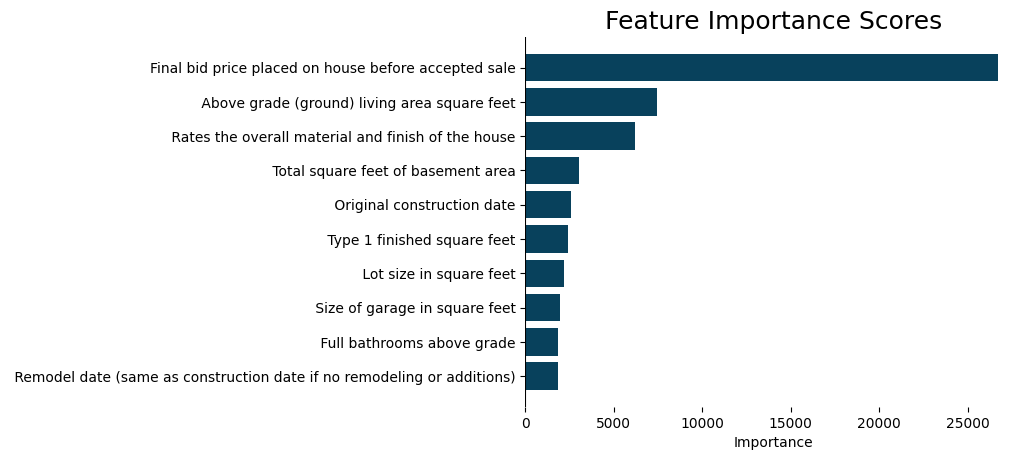

In [20]:
from pyreal.explainers import GlobalFeatureImportance, LocalFeatureContribution
## Changed to be used with pyreal version 0.4.10
from pyreal.visualize import feature_bar_plot, strip_plot

feature_descriptions = dict(zip(feature_df.name, feature_df.description))

categorical_features = X_train.select_dtypes(exclude=[np.number]).columns
ohe = OneHotEncoder(columns=categorical_features)
scaler = DataFrameWrapper(StandardScaler())

ohe.fit(pd.concat((X_train, X_test), axis=0))
scaler.fit(ohe.transform(X_train))

global_explainer = GlobalFeatureImportance(model_orig, x_train_orig=X_train,
                                           e_algorithm="shap", transformers=[ohe, scaler],
                                           feature_descriptions=feature_descriptions,
                                           fit_on_init=True)

explanation = global_explainer.produce()
feature_bar_plot(explanation, num_features=10)

Now, use the example above as well as additional documentation [here](https://dtail.gitbook.io/pyreal/getting-started/quickstart) to generate a Local Feature Contribution explanation, which will give you further information about the exact positive and negative contributions of each feature.

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.


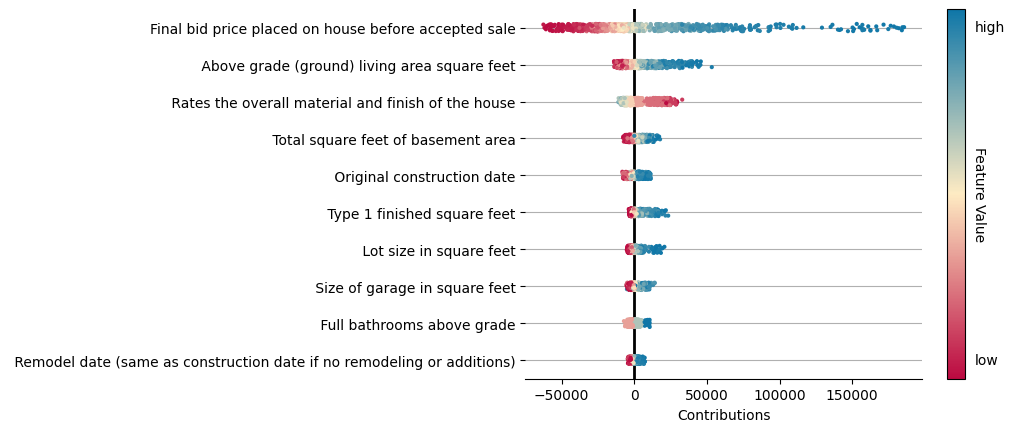

In [21]:
local_explainer = LocalFeatureContribution(model_orig, x_train_orig=X_train,
                                           e_algorithm="shap", transformers=[ohe, scaler],
                                           feature_descriptions=feature_descriptions,
                                           fit_on_init=True)

# local_explanation, x_interpret = # your code here #
local_explanation = local_explainer.produce(X_train)
strip_plot(local_explanation, num_features=10, type="strip")

You can now look at multiple individual explanations individually using `plot_top_contributors`, or you may find it more useful to generate a swarm plot like the ones above using Pyreals [swarm_plot](https://sibyl-ml.dev/pyreal/api_reference/api/pyreal.utils.visualize.swarm_plot.html#pyreal.utils.visualize.swarm_plot) function.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


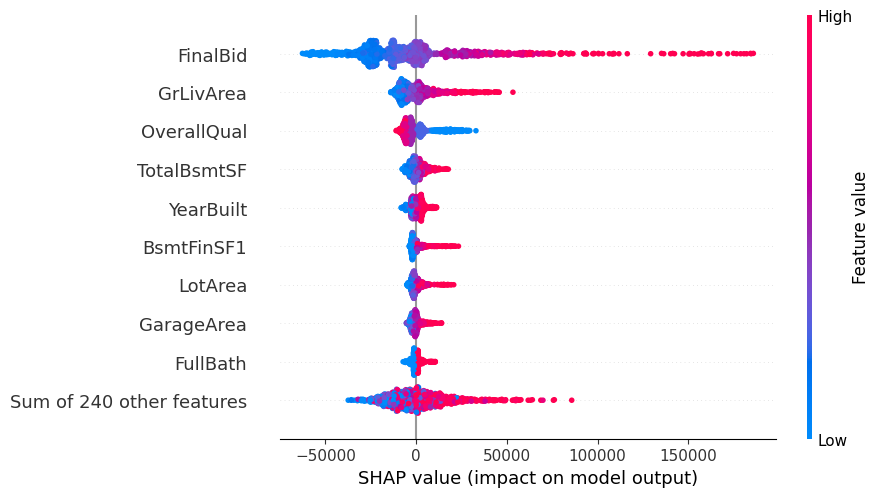

In [24]:
# your code here #
explain(model_orig, X_train_std)

In [25]:
feature_descriptions["OverallQual"]

' Rates the overall material and finish of the house'

### Results

As you may have determined from the explanations above, the data has two flaws.

<details>
<summary><font color='blue'> Click to reveal solution </font></summary>The first is an example of **data leakage**, by including a feature for the bid price on houses sold in the past. We won't have access to the information for new houses on the market, so a model that relies heavily on this information will not be useful for setting the original house price.

The second was a mistake in the engineering of features, resulting in higher quality of housing materials leading to lower model predictions. If this mistake does not exist in new data coming in, we can expect model performance to decrease.
</details>

### Bonus activity

If you'd like to get more experience with generating interpretable features, try finding a dataset on a topic you know a lot about. Generate features based on information you know is important, and then compare the explanations and performance to features generated automatically using a tool like the ones above.